In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import numpy as np
import matplotlib as plt
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/root/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### Content

1. Basic implementation
2. MNIST
3. Permuted MNIST
4. Hidden state evolution
5. Optimized implementation
6. CIFAR10

### Basic implementation

In [19]:
class AntisymmetricRNN(nn.Module):
    def __init__(self, input_dim, output_classes, n_units=32, eps=0.01, gamma=0.01, use_gating=True, init_W_std=1,
                 is_cuda=True):
        super(AntisymmetricRNN, self).__init__()
        
        #init Vh 
        normal_sampler_V = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([1/input_dim]))
        Vh_init_weight = nn.Parameter(normal_sampler_V.sample((n_units, input_dim))[..., 0])
        Vh_init_bias = nn.Parameter(torch.zeros(n_units))
        self.Vh = nn.Linear(input_dim, n_units)
        self.Vh.weight = Vh_init_weight
        self.Vh.bias = Vh_init_bias
        
        if use_gating:
            #init Vz 
            Vz_init_weight = nn.Parameter(normal_sampler_V.sample((n_units, input_dim))[..., 0])
            # init input gate open by setting bias term equal to 1
            #Vz_init_bias = nn.Parameter(torch.ones(n_units))
            Vz_init_bias = nn.Parameter(torch.zeros(n_units))
            self.Vz = nn.Linear(input_dim, n_units)
            self.Vz.weight = Vz_init_weight
            self.Vz.bias = Vz_init_bias
        
        #init W
        normal_sampler_W = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([init_W_std/n_units]))
        self.W = nn.Parameter(normal_sampler_W.sample((n_units, n_units))[..., 0])
        
        #init diffusion
        self.gamma_I = torch.eye(n_units, n_units)*gamma
        if is_cuda:
            self.gamma_I = self.gamma_I.cuda()
        
        self.eps = eps
        self.use_gating = use_gating
        self.is_cuda = is_cuda
        self.n_units = n_units
        
        self.fully_connected = nn.Linear(n_units, output_classes)
    def forward(self, x):
        # x.shape = (batch_size, timesteps, input_dim)
        h = torch.zeros(x.shape[0], self.n_units)
        if self.is_cuda:
            h = h.cuda()
        T = x.shape[1]
        
        if not self.use_gating:
            for t in range(T):
                # (W - WT - gammaI)h
                WmWT_h = torch.matmul(h, (self.W - self.W.transpose(1, 0) - self.gamma_I))
                
                # Vhx + bh
                Vh_x = self.Vh(x[:, t, :])
                
                # (W - WT - gammaI)h + Vhx + bh
                linear_transform = WmWT_h + Vh_x
                
                # tanh((W - WT - gammaI)h + Vhx + bh)
                f = torch.tanh(linear_transform)
                
                #eq. 12
                h = h + self.eps*f
        else:
            for t in range(T):
                # (W - WT - gammaI)h
                WmWT_h = torch.matmul(h, (self.W - self.W.transpose(1, 0) - self.gamma_I))
                
                # Vhx + bh
                Vh_x = self.Vh(x[:, t, :])
                
                # (W - WT - gammaI)h + Vhx + bh
                linear_transform1 = WmWT_h + Vh_x
                
                # Vzx + bz
                Vz_x = self.Vz(x[:, t, :])
                
                # (W - WT - gammaI)h +Vzx + bz
                linear_transform2 = WmWT_h + Vz_x
                
                # tanh((W - WT - gammaI)h + Vhx + bh)*sigm((W - WT - gammaI)h + Vzx + bz)
                f = torch.tanh(linear_transform1)*torch.sigmoid(linear_transform2)
                #eq. 13
                h = h + self.eps*f
        out = self.fully_connected(h)
        
        return out

### MNIST

In [20]:
import torchvision

In [21]:
train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ]))


test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ]))

In [22]:
x_train = train.train_data
y_train = train.train_labels

In [23]:
x_test = test.test_data
y_test = test.test_labels

In [24]:
x_train[0], y_train[0]

(tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
           18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

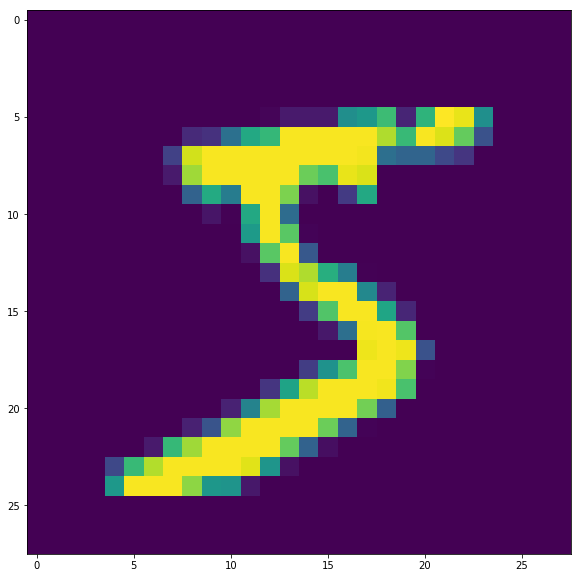

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(x_train[0, :, :].numpy())

In [26]:
x_train_f = []
for i in range(x_train.shape[0]):
    x_train_f.append(x_train[i].flatten())
x_train_f = torch.stack(x_train_f)
x_train_f = x_train_f.unsqueeze(2)

In [27]:
x_test_f = []
for i in range(x_test.shape[0]):
    x_test_f.append(x_test[i].flatten())
x_test_f = torch.stack(x_test_f)
x_test_f = x_test_f.unsqueeze(2)

In [28]:
x_train_f.shape, x_test_f.shape

(torch.Size([60000, 784, 1]), torch.Size([10000, 784, 1]))

In [29]:
x_train_f = x_train_f.float()
x_test_f = x_test_f.float()

In [30]:
x_train_f /= 255
x_test_f /= 255

In [31]:
train_loader = DataLoader(TensorDataset(x_train_f, y_train), shuffle=True, batch_size=128)
test_loader = DataLoader(TensorDataset(x_test_f, y_test), shuffle=True, batch_size=128)

In [43]:
model = AntisymmetricRNN(1, 10, n_units=128, gamma=0.01, eps=0.01).cuda()
opt = torch.optim.Adagrad(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss()

In [44]:
import time

In [45]:
for e in range(1000):
    time_start = time.time()
    ce_train, ce_test, acc_train, acc_test = 0, 0, 0, 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        output = model(batch_x)
        l = loss(output, batch_y.long())
        l.backward()
        opt.step()
        ce_train += l.item()*batch_x.shape[0]
        _, preds = torch.max(output, 1)
        acc_train += (preds == batch_y).sum().item()
    ce_train /= len(x_train_f)
    acc_train = acc_train*100/len(x_train_f)
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)
            l = loss(output, batch_y.long())
            ce_test += l.item()*batch_x.shape[0]
            _, preds = torch.max(output, 1)
            acc_test += (preds == batch_y).sum().item()
    ce_test /= len(x_test_f)
    acc_test = acc_test*100/len(x_test_f)
    time_end = time.time()
    print("Iter: ", e, "train loss: ", ce_train, "train acc: ", acc_train,
          "test loss: ", ce_test, "test acc: ", acc_test, "iter time: ", time_end - time_start)

Iter:  0 train loss:  1.2870304822603862 train acc:  55.538333333333334 test loss:  0.7726918192863464 test acc:  73.66 iter time:  234.1330738067627
Iter:  1 train loss:  0.721573659992218 train acc:  75.35166666666667 test loss:  0.6349810194015503 test acc:  78.4 iter time:  231.45189881324768
Iter:  2 train loss:  0.6091690582116445 train acc:  79.28 test loss:  0.5955559228420257 test acc:  79.85 iter time:  233.4731888771057
Iter:  3 train loss:  0.5303869179089864 train acc:  82.14 test loss:  0.5341317306756973 test acc:  82.07 iter time:  236.02361941337585
Iter:  4 train loss:  0.47110583457946775 train acc:  84.31666666666666 test loss:  0.47677757902145385 test acc:  84.78 iter time:  237.58435773849487
Iter:  5 train loss:  0.42054990599950154 train acc:  86.155 test loss:  0.5371652351379395 test acc:  82.14 iter time:  231.56469631195068
Iter:  6 train loss:  0.3871408078988393 train acc:  87.425 test loss:  0.3876601119041443 test acc:  87.77 iter time:  234.08534836769

Iter:  56 train loss:  0.12771023038228352 train acc:  95.735 test loss:  0.2290937584400177 test acc:  92.68 iter time:  279.6928939819336
Iter:  57 train loss:  0.1280131965359052 train acc:  95.9 test loss:  0.2126358630657196 test acc:  93.35 iter time:  261.98912596702576
Iter:  58 train loss:  0.1266639477054278 train acc:  95.84666666666666 test loss:  0.19694681267738343 test acc:  93.81 iter time:  255.6738305091858
Iter:  59 train loss:  0.12477150483926137 train acc:  95.97833333333334 test loss:  0.22465879459381102 test acc:  93.1 iter time:  260.89163088798523
Iter:  60 train loss:  0.12213674991925558 train acc:  96.125 test loss:  0.2322024800300598 test acc:  92.84 iter time:  236.15626645088196
Iter:  61 train loss:  0.12343060595989228 train acc:  96.035 test loss:  0.20811056170463563 test acc:  93.53 iter time:  223.8347668647766
Iter:  62 train loss:  0.12051486543814341 train acc:  96.04666666666667 test loss:  0.20901079549789428 test acc:  93.25 iter time:  225

KeyboardInterrupt: 

In [46]:
torch.save(model.state_dict(), "asrnn_mnist.pt")

In [47]:
predicts = []
true = []
outs = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        _, preds = torch.max(output, 1)
        predicts.append(preds.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        outs.append(output.detach().cpu().numpy())
predicts = np.concatenate(predicts)
true = np.concatenate(true)
outs = np.concatenate(outs)

In [48]:
outs[:5]

array([[ 3.5931036 , -5.9757814 ,  2.9614336 , -5.5756984 ,  1.1678203 ,
         4.6544094 , 15.690162  , -8.226472  , -0.6495551 , -4.649786  ],
       [-6.4223275 , -2.5988266 ,  0.85233784,  9.68976   , -5.710304  ,
         4.6671867 , -4.578056  , -0.6419372 ,  3.4735177 ,  0.71095073],
       [11.074766  , -4.210854  ,  3.5198138 , -2.351983  , -2.3258173 ,
        -4.734749  , -2.038348  , -5.865161  ,  3.306027  ,  1.054817  ],
       [-5.8444357 ,  1.8769943 , -3.73406   ,  0.19853258, 11.320702  ,
        -0.64667326, -3.5076833 ,  0.5065357 ,  0.50556487,  0.5207629 ],
       [-0.8665168 , -1.2605613 , -3.8659    , -0.69110423,  1.2467873 ,
        10.913241  ,  2.4842324 , -5.2337546 , -0.19543009, -3.1634147 ]],
      dtype=float32)

In [49]:
predicts[:5]

array([6, 3, 0, 4, 5])

In [50]:
true[:5]

array([6, 3, 0, 4, 5])

In [51]:
from sklearn.metrics import accuracy_score

In [52]:
accuracy_score(true, predicts)

0.9397

### Permuted MNIST

In [64]:
torch.manual_seed(42)
permuted_idx = torch.randperm(x_train_f.shape[1])

In [73]:
x_train_f_permuted = x_train_f[:, permuted_idx, :]
x_test_f_permuted = x_test_f[:, permuted_idx, :]

In [77]:
train_loader = DataLoader(TensorDataset(x_train_f_permuted, y_train), shuffle=True, batch_size=128)
test_loader = DataLoader(TensorDataset(x_test_f_permuted, y_test), shuffle=True, batch_size=128)

In [78]:
model = AntisymmetricRNN(1, 10, n_units=128, gamma=0.01, eps=0.01).cuda()
opt = torch.optim.Adagrad(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss()

In [79]:
for e in range(1000):
    time_start = time.time()
    ce_train, ce_test, acc_train, acc_test = 0, 0, 0, 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        output = model(batch_x)
        l = loss(output, batch_y.long())
        l.backward()
        opt.step()
        ce_train += l.item()*batch_x.shape[0]
        _, preds = torch.max(output, 1)
        acc_train += (preds == batch_y).sum().item()
    ce_train /= len(x_train_f)
    acc_train = acc_train*100/len(x_train_f)
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)
            l = loss(output, batch_y.long())
            ce_test += l.item()*batch_x.shape[0]
            _, preds = torch.max(output, 1)
            acc_test += (preds == batch_y).sum().item()
    ce_test /= len(x_test_f)
    acc_test = acc_test*100/len(x_test_f)
    time_end = time.time()
    print("Iter: ", e, "train loss: ", ce_train, "train acc: ", acc_train,
          "test loss: ", ce_test, "test acc: ", acc_test, "iter time: ", time_end - time_start)

Iter:  0 train loss:  1.574936691602071 train acc:  46.10666666666667 test loss:  1.048818241596222 test acc:  65.65 iter time:  255.8594470024109
Iter:  1 train loss:  0.8915311986287435 train acc:  70.365 test loss:  0.7229714169502258 test acc:  76.82 iter time:  252.3295590877533
Iter:  2 train loss:  0.7278116710344951 train acc:  75.95666666666666 test loss:  0.6497689222335815 test acc:  78.75 iter time:  253.1057825088501
Iter:  3 train loss:  0.6310983384132385 train acc:  79.405 test loss:  0.6555990331172943 test acc:  78.72 iter time:  242.26995754241943
Iter:  4 train loss:  0.569624704281489 train acc:  81.54833333333333 test loss:  0.5439296964645386 test acc:  82.3 iter time:  229.50448203086853
Iter:  5 train loss:  0.5313842254638672 train acc:  82.595 test loss:  0.5005411725044251 test acc:  83.52 iter time:  234.06840658187866
Iter:  6 train loss:  0.4948198158899943 train acc:  84.02 test loss:  0.4705750469684601 test acc:  84.98 iter time:  240.44304394721985
It

KeyboardInterrupt: 

In [112]:
predicts = []
true = []
outs = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        _, preds = torch.max(output, 1)
        predicts.append(preds.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        outs.append(output.detach().cpu().numpy())
predicts = np.concatenate(predicts)
true = np.concatenate(true)
outs = np.concatenate(outs)

In [113]:
accuracy_score(true, predicts)

0.8937

### Hidden state evolution

In [80]:
class AntisymmetricRNNCell(nn.Module):
    def __init__(self, input_dim, n_units, eps, gamma, init_W_std=1):
        super(AntisymmetricRNNCell, self).__init__()
        
        #init Vh 
        normal_sampler_V = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([1/input_dim]))
        self.Vh_weight = nn.Parameter(normal_sampler_V.sample((input_dim, n_units))[..., 0])
        self.Vh_bias = nn.Parameter(torch.zeros(n_units))
        
        #init W
        normal_sampler_W = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([init_W_std/n_units]))
        self.W = nn.Parameter(normal_sampler_W.sample((n_units, n_units))[..., 0])
        
        #init diffusion
        self.gamma_I = nn.Parameter(torch.eye(n_units, n_units)*gamma, requires_grad=False)
        
        self.eps = nn.Parameter(torch.Tensor([eps]), requires_grad=False)
        
        
    
    def forward(self, x, h):
        # (W - WT - gammaI)h
        WmWT_h = torch.matmul(h, (self.W - self.W.transpose(1, 0) - self.gamma_I))
        #print(x.shape, self.Vh_weight.shape)
        # Vhx + bh
        Vh_x = torch.matmul(x, self.Vh_weight) + self.Vh_bias

        # (W - WT - gammaI)h + Vhx + bh
        linear_transform = WmWT_h + Vh_x

        # tanh((W - WT - gammaI)h + Vhx + bh)
        f = torch.tanh(linear_transform)

        #eq. 12
        h = h + self.eps*f
        return h
    
class AntisymmetricGatingRNNCell(nn.Module):
    def __init__(self, input_dim, n_units, eps, gamma, init_W_std):
        super(AntisymmetricGatingRNNCell, self).__init__()
        
        #init Vh 
        normal_sampler_V = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([1/input_dim]))
        self.Vh_weight = nn.Parameter(normal_sampler_V.sample((input_dim, n_units))[..., 0])
        self.Vh_bias = nn.Parameter(torch.zeros(n_units))
        
        #init Vz 
        self.Vz_weight = nn.Parameter(normal_sampler_V.sample((input_dim, n_units))[..., 0])
        # init input gate open by setting bias term equal to 1
        self.Vz_bias = nn.Parameter(torch.ones(n_units))
        #self.Vz_bias = nn.Parameter(torch.zeros(n_units))
        
        #init W
        normal_sampler_W = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([init_W_std/n_units]))
        self.W = nn.Parameter(normal_sampler_W.sample((n_units, n_units))[..., 0])
        
        #init diffusion
        self.gamma_I = nn.Parameter(torch.eye(n_units, n_units)*gamma, requires_grad=False)
        
        self.eps = nn.Parameter(torch.Tensor([eps]), requires_grad=False)
    
    
    def forward(self, x, h):
        WmWT_h = torch.matmul(h, (self.W - self.W.transpose(1, 0) - self.gamma_I))
                
        # Vhx + bh
        Vh_x = torch.matmul(x, self.Vh_weight) + self.Vh_bias
        

        # (W - WT - gammaI)h + Vhx + bh
        linear_transform1 = WmWT_h + Vh_x

        # Vzx + bz
        Vz_x = torch.matmul(x, self.Vz_weight) + self.Vz_bias

        # (W - WT - gammaI)h +Vzx + bz
        linear_transform2 = WmWT_h + Vz_x

        # tanh((W - WT - gammaI)h + Vhx + bh)*sigm((W - WT - gammaI)h + Vzx + bz)
        f = torch.tanh(linear_transform1)*torch.sigmoid(linear_transform2)
        #eq. 13
        h = h + self.eps*f
        
        return h

In [83]:
as_cell = AntisymmetricRNNCell(2, 2, 0.01, 0.01, 1.0)
as_cell_g = AntisymmetricGatingRNNCell(2, 2, 0.01, 0.01, 1.0)
as_cell_g.Vz_bias = nn.Parameter(torch.Tensor([0, 0]), requires_grad=False)

In [84]:
lstm_cell = nn.LSTMCell(2, 2, bias=False)
gru_cell = nn.GRUCell(2, 2, bias=False)
rnn_cell = nn.RNNCell(2, 2, bias=False)

In [89]:
#ensure there is no non-zero bias in recurrent cells

In [90]:
list(lstm_cell.parameters()), list(gru_cell.parameters()), list(rnn_cell.parameters())

([Parameter containing:
  tensor([[-0.1307,  0.0081],
          [ 0.4428,  0.5287],
          [ 0.2663, -0.4021],
          [ 0.6473,  0.6768],
          [ 0.6631,  0.1976],
          [-0.1751,  0.1975],
          [ 0.5813, -0.0076],
          [ 0.7038,  0.1288]], requires_grad=True), Parameter containing:
  tensor([[ 0.4371,  0.6728],
          [ 0.4598, -0.1104],
          [-0.5043,  0.2670],
          [-0.1818, -0.5825],
          [ 0.5079, -0.2994],
          [ 0.3062, -0.3189],
          [-0.6595, -0.2883],
          [-0.7028, -0.5002]], requires_grad=True)], [Parameter containing:
  tensor([[-0.4556,  0.5855],
          [-0.1275,  0.0716],
          [ 0.1021,  0.5697],
          [-0.6401,  0.3656],
          [-0.2727,  0.5013],
          [ 0.1214,  0.4754]], requires_grad=True), Parameter containing:
  tensor([[ 0.5770,  0.5305],
          [-0.5951,  0.2252],
          [-0.3235, -0.1696],
          [ 0.0750, -0.3468],
          [-0.3023, -0.4298],
          [-0.4493,  0.6852]], r

In [91]:
list(as_cell.parameters()), list(as_cell_g.parameters())

([Parameter containing:
  tensor([[-0.1154,  0.7602],
          [-0.3477,  0.0998]], requires_grad=True), Parameter containing:
  tensor([0., 0.], requires_grad=True), Parameter containing:
  tensor([[-0.0771,  0.3104],
          [-0.3739,  0.1242]], requires_grad=True), Parameter containing:
  tensor([[0.0100, 0.0000],
          [0.0000, 0.0100]]), Parameter containing:
  tensor([0.0100])], [Parameter containing:
  tensor([[ 0.0959,  0.3852],
          [ 0.1509, -0.3881]], requires_grad=True), Parameter containing:
  tensor([0., 0.], requires_grad=True), Parameter containing:
  tensor([[-0.2340,  0.1024],
          [-0.3953, -0.1397]], requires_grad=True), Parameter containing:
  tensor([0., 0.]), Parameter containing:
  tensor([[ 0.0786, -0.1643],
          [ 0.0059,  0.3475]], requires_grad=True), Parameter containing:
  tensor([[0.0100, 0.0000],
          [0.0000, 0.0100]]), Parameter containing:
  tensor([0.0100])])

In [92]:
# init different hidden states and zero input

In [93]:
h1 = torch.Tensor([[0, 0.5]])
h2 = torch.Tensor([[-0.5, -0.5]])
h3 = torch.Tensor([[0.5, -0.75]])
x = torch.zeros(1, 2)

In [106]:
as_cell_hs1 = []
as_cell_hs2 = []
as_cell_hs3 = []

with torch.no_grad():
    h = h1
    for t in range(15000):
        h = as_cell(x, h)
        as_cell_hs1.append(h.detach().numpy())
    h = h2
    for t in range(15000):
        h = as_cell(x, h)
        as_cell_hs2.append(h.detach().numpy())
    h = h3
    for t in range(15000):
        h = as_cell(x, h)
        as_cell_hs3.append(h.detach().numpy())
as_cell_hs1 = np.concatenate(as_cell_hs1)
as_cell_hs2 = np.concatenate(as_cell_hs2)
as_cell_hs3 = np.concatenate(as_cell_hs3)

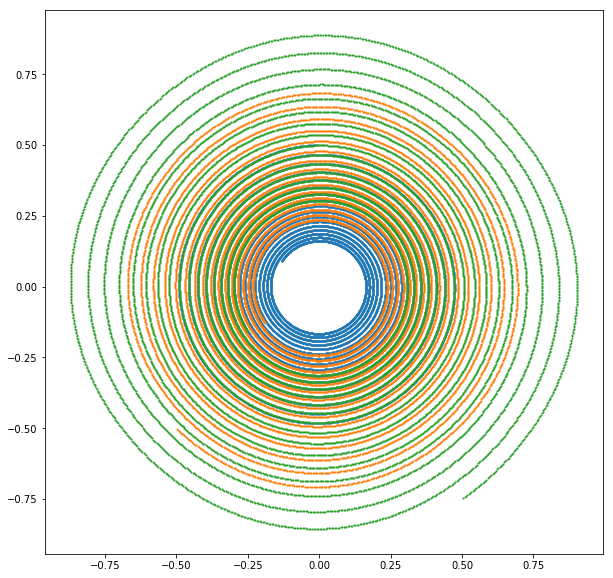

In [107]:
plt.figure(figsize=(10, 10))
plt.scatter(as_cell_hs1[:, 0], as_cell_hs1[:, 1], s=1.0)
plt.scatter(as_cell_hs2[:, 0], as_cell_hs2[:, 1], s=1.0)
plt.scatter(as_cell_hs3[:, 0], as_cell_hs3[:, 1], s=1.0)

In [108]:
as_cell_g_hs1 = []
as_cell_g_hs2 = []
as_cell_g_hs3 = []
with torch.no_grad():
    h = h1
    for t in range(15000):
        h = as_cell_g(x, h)
        as_cell_g_hs1.append(h.detach().numpy())
    h = h2
    for t in range(15000):
        h = as_cell_g(x, h)
        as_cell_g_hs2.append(h.detach().numpy())
    h = h3
    for t in range(15000):
        h = as_cell_g(x, h)
        as_cell_g_hs3.append(h.detach().numpy())
as_cell_g_hs1 = np.concatenate(as_cell_g_hs1)
as_cell_g_hs2 = np.concatenate(as_cell_g_hs2)
as_cell_g_hs3 = np.concatenate(as_cell_g_hs3)

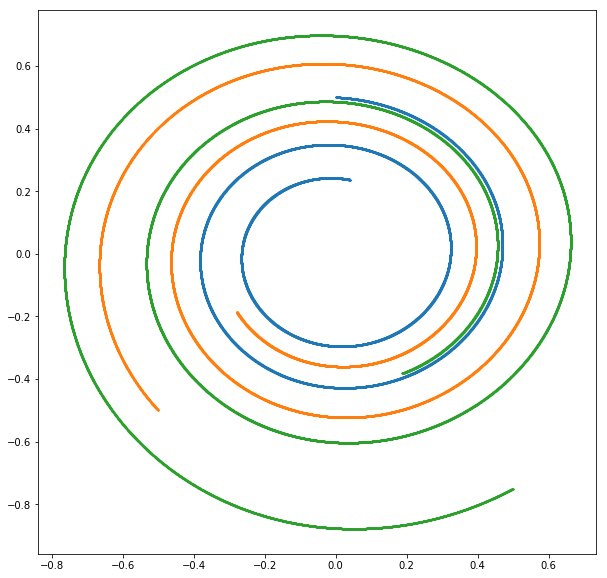

In [109]:
plt.figure(figsize=(10, 10))
plt.scatter(as_cell_g_hs1[:, 0], as_cell_g_hs1[:, 1], s=1.0)
plt.scatter(as_cell_g_hs2[:, 0], as_cell_g_hs2[:, 1], s=1.0)
plt.scatter(as_cell_g_hs3[:, 0], as_cell_g_hs3[:, 1], s=1.0)

In [110]:
gru_cell_hs1 = []
gru_cell_hs2 = []
gru_cell_hs3 = []
with torch.no_grad():
    h = h1
    for t in range(15000):
        h = gru_cell(x, h)
        gru_cell_hs1.append(h.detach().numpy())
    h = h2
    for t in range(15000):
        h = gru_cell(x, h)
        gru_cell_hs2.append(h.detach().numpy())
    h = h3
    for t in range(15000):
        h = gru_cell(x, h)
        gru_cell_hs3.append(h.detach().numpy())
gru_cell_hs1 = np.concatenate(gru_cell_hs1)
gru_cell_hs2 = np.concatenate(gru_cell_hs2)
gru_cell_hs3 = np.concatenate(gru_cell_hs3)

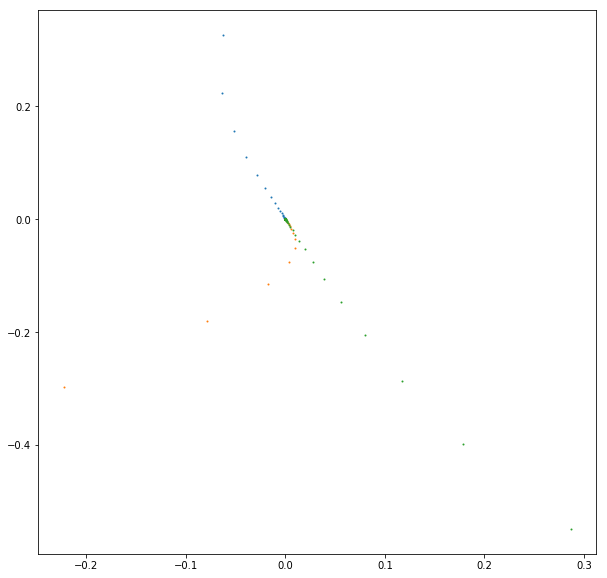

In [111]:
plt.figure(figsize=(10, 10))
plt.scatter(gru_cell_hs1[:, 0], gru_cell_hs1[:, 1], s=1.0)
plt.scatter(gru_cell_hs2[:, 0], gru_cell_hs2[:, 1], s=1.0)
plt.scatter(gru_cell_hs3[:, 0], gru_cell_hs3[:, 1], s=1.0)

In [114]:
lstm_cell_hs1 = []
lstm_cell_hs2 = []
lstm_cell_hs3 = []
with torch.no_grad():
    h = h1
    for t in range(15000):
        h, c = lstm_cell(x, (h, x))
        lstm_cell_hs1.append(h.detach().numpy())
    h = h2
    for t in range(15000):
        h, c = lstm_cell(x, (h, x))
        lstm_cell_hs2.append(h.detach().numpy())
    h = h3
    for t in range(15000):
        h, c = lstm_cell(x, (h, x))
        lstm_cell_hs3.append(h.detach().numpy())
lstm_cell_hs1 = np.concatenate(lstm_cell_hs1)
lstm_cell_hs2 = np.concatenate(lstm_cell_hs2)
lstm_cell_hs3 = np.concatenate(lstm_cell_hs3)

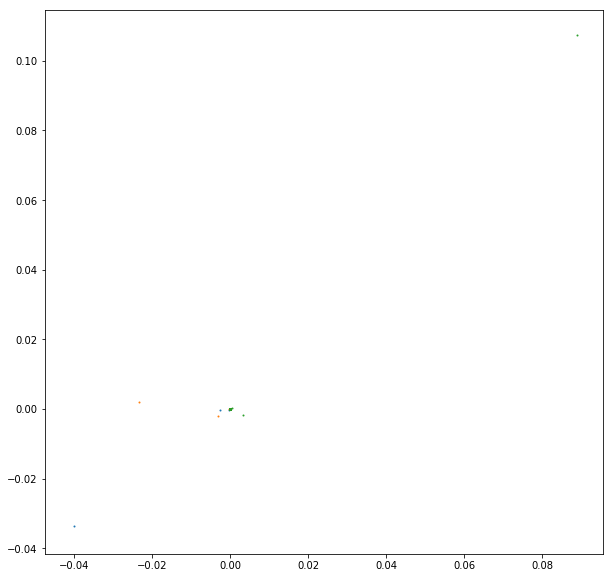

In [116]:
plt.figure(figsize=(10, 10))
plt.scatter(lstm_cell_hs1[:, 0], lstm_cell_hs1[:, 1], s=1.0)
plt.scatter(lstm_cell_hs2[:, 0], lstm_cell_hs2[:, 1], s=1.0)
plt.scatter(lstm_cell_hs3[:, 0], lstm_cell_hs3[:, 1], s=1.0)

In [117]:
rnn_cell_hs1 = []
rnn_cell_hs2 = []
rnn_cell_hs3 = []
with torch.no_grad():
    h = h1
    for t in range(15000):
        h = rnn_cell(x, h)
        rnn_cell_hs1.append(h.detach().numpy())
    h = h2
    for t in range(15000):
        h = rnn_cell(x, h)
        rnn_cell_hs2.append(h.detach().numpy())
    h = h3
    for t in range(15000):
        h = rnn_cell(x, h)
        rnn_cell_hs3.append(h.detach().numpy())
rnn_cell_hs1 = np.concatenate(rnn_cell_hs1)
rnn_cell_hs2 = np.concatenate(rnn_cell_hs2)
rnn_cell_hs3 = np.concatenate(rnn_cell_hs3)

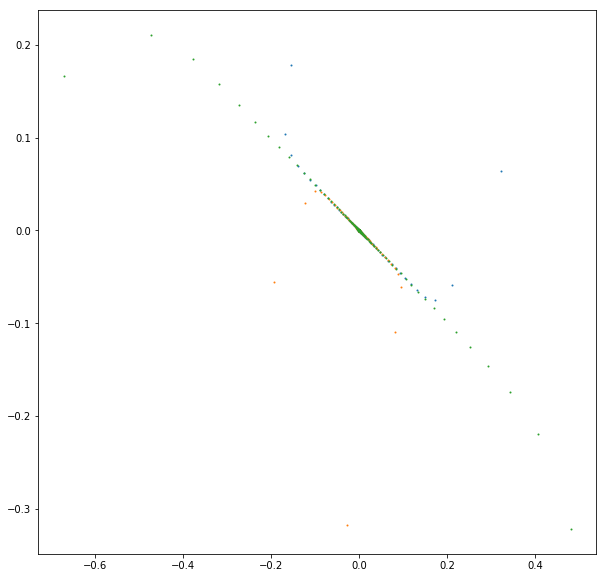

In [118]:
plt.figure(figsize=(10, 10))
plt.scatter(rnn_cell_hs1[:, 0], rnn_cell_hs1[:, 1], s=1.0)
plt.scatter(rnn_cell_hs2[:, 0], rnn_cell_hs2[:, 1], s=1.0)
plt.scatter(rnn_cell_hs3[:, 0], rnn_cell_hs3[:, 1], s=1.0)

Eigen values of hidden state transformation matrix in antisymmetric rnn cells

In [123]:
transform = as_cell.W.detach().numpy() - as_cell.W.detach().numpy().transpose() - as_cell.gamma_I.detach().numpy()

In [124]:
np.linalg.eigvals(transform)

array([-0.01+0.68435013j, -0.01-0.68435013j], dtype=complex64)

If gamma is equal to zero

In [126]:
as_cell_zero_gamma = AntisymmetricRNNCell(2, 2, 0.01, 0, 1.0)

In [127]:
as_cell_zero_gamma_hs1 = []
as_cell_zero_gamma_hs2 = []
as_cell_zero_gamma_hs3 = []

with torch.no_grad():
    h = h1
    for t in range(15000):
        h = as_cell_zero_gamma(x, h)
        as_cell_zero_gamma_hs1.append(h.detach().numpy())
    h = h2
    for t in range(15000):
        h = as_cell_zero_gamma(x, h)
        as_cell_zero_gamma_hs2.append(h.detach().numpy())
    h = h3
    for t in range(15000):
        h = as_cell_zero_gamma(x, h)
        as_cell_zero_gamma_hs3.append(h.detach().numpy())
as_cell_zero_gamma_hs1 = np.concatenate(as_cell_zero_gamma_hs1)
as_cell_zero_gamma_hs2 = np.concatenate(as_cell_zero_gamma_hs2)
as_cell_zero_gamma_hs3 = np.concatenate(as_cell_zero_gamma_hs3)

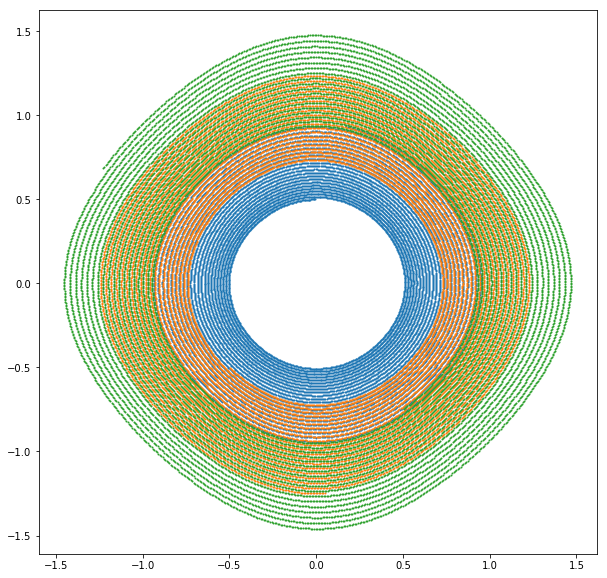

In [128]:
plt.figure(figsize=(10, 10))
plt.scatter(as_cell_zero_gamma_hs1[:, 0], as_cell_zero_gamma_hs1[:, 1], s=1.0)
plt.scatter(as_cell_zero_gamma_hs2[:, 0], as_cell_zero_gamma_hs2[:, 1], s=1.0)
plt.scatter(as_cell_zero_gamma_hs3[:, 0], as_cell_zero_gamma_hs3[:, 1], s=1.0)

In [132]:
transform_zero_gamma = as_cell_zero_gamma.W.detach().numpy() - as_cell_zero_gamma.W.detach().numpy().transpose() - \
            as_cell_zero_gamma.gamma_I.detach().numpy()

In [133]:
np.linalg.eigvals(transform_zero_gamma)

array([0.+1.0419827j, 0.-1.0419827j], dtype=complex64)

Hidden states still converge to (0, 0) point even when eigenvalues have real parts equal to zero.
This happens because of Euler discritization scheme instability.
If one will decrease eps and increase number of steps, following hidden state evolution will be observed:

In [139]:
as_cell_zero_gamma = AntisymmetricRNNCell(2, 2, 0.0001, 0, 1.0)

In [140]:
as_cell_zero_gamma_hs1 = []

with torch.no_grad():
    h = h1
    for t in range(1500000):
        h = as_cell_zero_gamma(x, h)
        as_cell_zero_gamma_hs1.append(h.detach().numpy())
as_cell_zero_gamma_hs1 = np.concatenate(as_cell_zero_gamma_hs1)

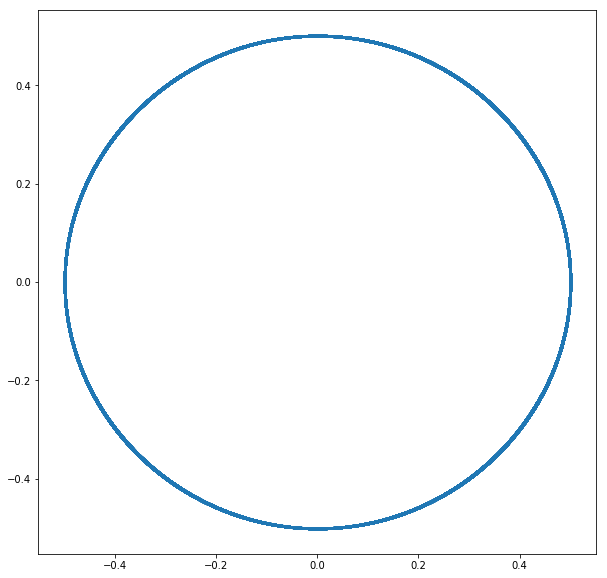

In [141]:
plt.figure(figsize=(10, 10))
plt.scatter(as_cell_zero_gamma_hs1[:, 0], as_cell_zero_gamma_hs1[:, 1], s=1.0)

Also, interesting evolution patterns can be obtained through (eps, gamma, init_W_std) grid search. For example:

In [155]:
as_cell = AntisymmetricRNNCell(2, 2, 0.1, 0.01, 1.0)

In [156]:
as_cell_hs1 = []
as_cell_hs2 = []
as_cell_hs3 = []

with torch.no_grad():
    h = h1
    for t in range(15000):
        h = as_cell(x, h)
        as_cell_hs1.append(h.detach().numpy())
    h = h2
    for t in range(15000):
        h = as_cell(x, h)
        as_cell_hs2.append(h.detach().numpy())
    h = h3
    for t in range(15000):
        h = as_cell(x, h)
        as_cell_hs3.append(h.detach().numpy())
as_cell_hs1 = np.concatenate(as_cell_hs1)
as_cell_hs2 = np.concatenate(as_cell_hs2)
as_cell_hs3 = np.concatenate(as_cell_hs3)

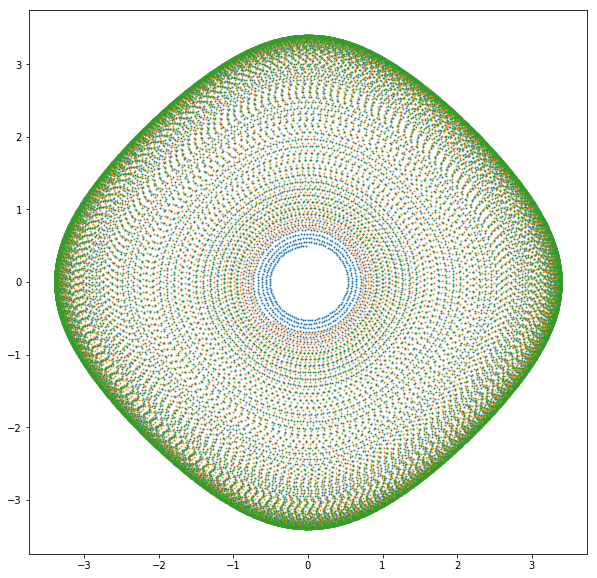

In [157]:
plt.figure(figsize=(10, 10))
plt.scatter(as_cell_hs1[:, 0], as_cell_hs1[:, 1], s=1.0)
plt.scatter(as_cell_hs2[:, 0], as_cell_hs2[:, 1], s=1.0)
plt.scatter(as_cell_hs3[:, 0], as_cell_hs3[:, 1], s=1.0)

In [166]:
transform = as_cell.W.detach().numpy() - as_cell.W.detach().numpy().transpose() - as_cell.gamma_I.detach().numpy()

In [167]:
np.linalg.eigvals(transform)

array([-0.01+0.6307739j, -0.01-0.6307739j], dtype=complex64)

### Optimized implementation

In [158]:
class AntisymmetricRNNCell(torch.jit.ScriptModule):
    def __init__(self, input_dim, n_units, eps, gamma, init_W_std=1):
        super(AntisymmetricRNNCell, self).__init__()
        
        #init Vh 
        normal_sampler_V = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([1/input_dim]))
        self.Vh_weight = nn.Parameter(normal_sampler_V.sample((input_dim, n_units))[..., 0])
        self.Vh_bias = nn.Parameter(torch.zeros(n_units))
        
        #init W
        normal_sampler_W = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([init_W_std/n_units]))
        self.W = nn.Parameter(normal_sampler_W.sample((n_units, n_units))[..., 0])
        
        #init diffusion
        self.gamma_I = nn.Parameter(torch.eye(n_units, n_units)*gamma, requires_grad=False)
        
        self.eps = nn.Parameter(torch.Tensor([eps]), requires_grad=False)
        
        
    @torch.jit.script_method
    def forward(self, x, h):
        # (W - WT - gammaI)h
        WmWT_h = torch.matmul(h, (self.W - self.W.transpose(1, 0) - self.gamma_I))
        #print(x.shape, self.Vh_weight.shape)
        # Vhx + bh
        Vh_x = torch.matmul(x, self.Vh_weight) + self.Vh_bias

        # (W - WT - gammaI)h + Vhx + bh
        linear_transform = WmWT_h + Vh_x

        # tanh((W - WT - gammaI)h + Vhx + bh)
        f = torch.tanh(linear_transform)

        #eq. 12
        h = h + self.eps*f
        return h
    
class AntisymmetricGatingRNNCell(torch.jit.ScriptModule):
    def __init__(self, input_dim, n_units, eps, gamma, init_W_std):
        super(AntisymmetricGatingRNNCell, self).__init__()
        
        #init Vh 
        normal_sampler_V = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([1/input_dim]))
        self.Vh_weight = nn.Parameter(normal_sampler_V.sample((input_dim, n_units))[..., 0])
        self.Vh_bias = nn.Parameter(torch.zeros(n_units))
        
        #init Vz 
        self.Vz_weight = nn.Parameter(normal_sampler_V.sample((input_dim, n_units))[..., 0])
        # init input gate open by setting bias term equal to 1
        self.Vz_bias = nn.Parameter(torch.ones(n_units))
        #self.Vz_bias = nn.Parameter(torch.zeros(n_units))
        
        #init W
        normal_sampler_W = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([init_W_std/n_units]))
        self.W = nn.Parameter(normal_sampler_W.sample((n_units, n_units))[..., 0])
        
        #init diffusion
        self.gamma_I = nn.Parameter(torch.eye(n_units, n_units)*gamma, requires_grad=False)
        
        self.eps = nn.Parameter(torch.Tensor([eps]), requires_grad=False)
    
    @torch.jit.script_method
    def forward(self, x, h):
        WmWT_h = torch.matmul(h, (self.W - self.W.transpose(1, 0) - self.gamma_I))
                
        # Vhx + bh
        Vh_x = torch.matmul(x, self.Vh_weight) + self.Vh_bias
        

        # (W - WT - gammaI)h + Vhx + bh
        linear_transform1 = WmWT_h + Vh_x

        # Vzx + bz
        Vz_x = torch.matmul(x, self.Vz_weight) + self.Vz_bias

        # (W - WT - gammaI)h +Vzx + bz
        linear_transform2 = WmWT_h + Vz_x

        # tanh((W - WT - gammaI)h + Vhx + bh)*sigm((W - WT - gammaI)h + Vzx + bz)
        f = torch.tanh(linear_transform1)*torch.sigmoid(linear_transform2)
        #eq. 13
        h = h + self.eps*f
        
        return h
    
class AntisymmetricRNN(torch.jit.ScriptModule):
    def __init__(self, input_dim, n_units=32, eps=0.01, gamma=0.01, use_gating=True, init_W_std=1,
                 is_cuda=True):
        super(AntisymmetricRNN, self).__init__()
        
        if use_gating:
            self.cell = AntisymmetricGatingRNNCell(input_dim, n_units, eps, gamma, init_W_std)
        else:
            self.cell = AntisymmetricRNNCell(input_dim, n_units, eps, gamma, init_W_std)
        
        self.n_units = n_units
        
    @torch.jit.script_method
    def forward(self, x, h):
        #T = x.shape[1]
        x_ = x.unbind(1)
        outputs = torch.jit.annotate(List[Tensor], [])
        #outputs = []
        for t in range(len(x_)):
            #h = self.cell(x[:, t, :], h)
            h = self.cell(x_[t], h)
            outputs += [h]
        return torch.stack(outputs), h
    
class AntisymmetricRNNModel(torch.jit.ScriptModule):
    def __init__(self, input_dim, output_classes, n_units=32, eps=0.01, gamma=0.01, use_gating=True, init_W_std=1,
                 is_cuda=True):
        super(AntisymmetricRNNModel, self).__init__()
        self.asrnn = AntisymmetricRNN(input_dim, n_units, eps, gamma, use_gating, init_W_std)
        self.fully_connected = torch.jit.trace(nn.Linear(n_units, output_classes), torch.randn(128, n_units))
        self.is_cuda = is_cuda
        self.n_units = n_units
    
    @torch.jit.script_method
    def forward(self, x, h):

        output, h = self.asrnn(x, h)
        out = self.fully_connected(h)
        
        return out
    

### CIFAR10

In [159]:
train = torchvision.datasets.CIFAR10('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ]))


test = torchvision.datasets.CIFAR10('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ]))

Files already downloaded and verified
Files already downloaded and verified


In [160]:
x_train = train.train_data
y_train = train.train_labels

In [161]:
x_test = test.test_data
y_test = test.test_labels

In [164]:
x_train[1], y_train[1]

(array([[[154, 177, 187],
         [126, 137, 136],
         [105, 104,  95],
         ...,
         [ 91,  95,  71],
         [ 87,  90,  71],
         [ 79,  81,  70]],
 
        [[140, 160, 169],
         [145, 153, 154],
         [125, 125, 118],
         ...,
         [ 96,  99,  78],
         [ 77,  80,  62],
         [ 71,  73,  61]],
 
        [[140, 155, 164],
         [139, 146, 149],
         [115, 115, 112],
         ...,
         [ 79,  82,  64],
         [ 68,  70,  55],
         [ 67,  69,  55]],
 
        ...,
 
        [[175, 167, 166],
         [156, 154, 160],
         [154, 160, 170],
         ...,
         [ 42,  34,  36],
         [ 61,  53,  57],
         [ 93,  83,  91]],
 
        [[165, 154, 128],
         [156, 152, 130],
         [159, 161, 142],
         ...,
         [103,  93,  96],
         [123, 114, 120],
         [131, 121, 131]],
 
        [[163, 148, 120],
         [158, 148, 122],
         [163, 156, 133],
         ...,
         [143, 133, 139],
  

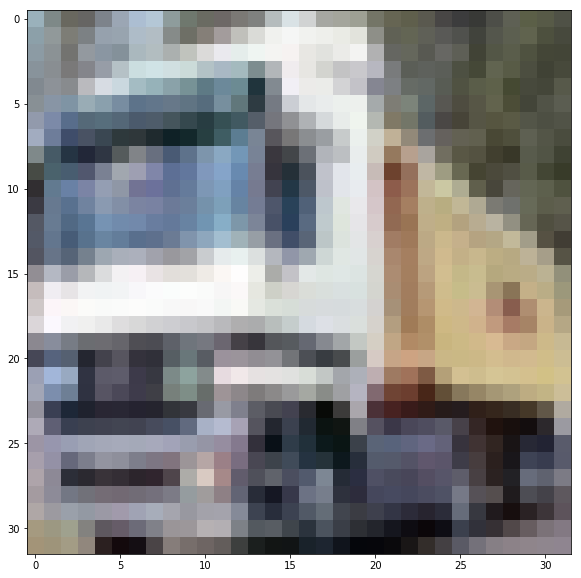

In [163]:
plt.figure(figsize=(10, 10))
plt.imshow(x_train[1, :, :])

In [165]:
x_train = torch.Tensor(x_train)
x_test = torch.Tensor(x_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

In [168]:
x_train.shape

torch.Size([50000, 32, 32, 3])

In [169]:
x_train_f = []
for i in range(x_train.shape[0]):
    x_train_f.append(x_train[i].view(-1, 3))
x_train_f = torch.stack(x_train_f)
x_train_f = x_train_f

In [170]:
x_test_f = []
for i in range(x_test.shape[0]):
    x_test_f.append(x_test[i].view(-1, 3))
x_test_f = torch.stack(x_test_f)
x_test_f = x_test_f

In [171]:
x_train_f.shape, x_test_f.shape

(torch.Size([50000, 1024, 3]), torch.Size([10000, 1024, 3]))

In [172]:
x_train_f = x_train_f.float()
x_test_f = x_test_f.float()

In [173]:
x_train_f /= 255
x_test_f /= 255

In [174]:
x_train_f.min(), x_train_f.max(), x_test_f.min(), x_test_f.max()

(tensor(0.), tensor(1.), tensor(0.), tensor(1.))

Flattened image to be classified

9.0


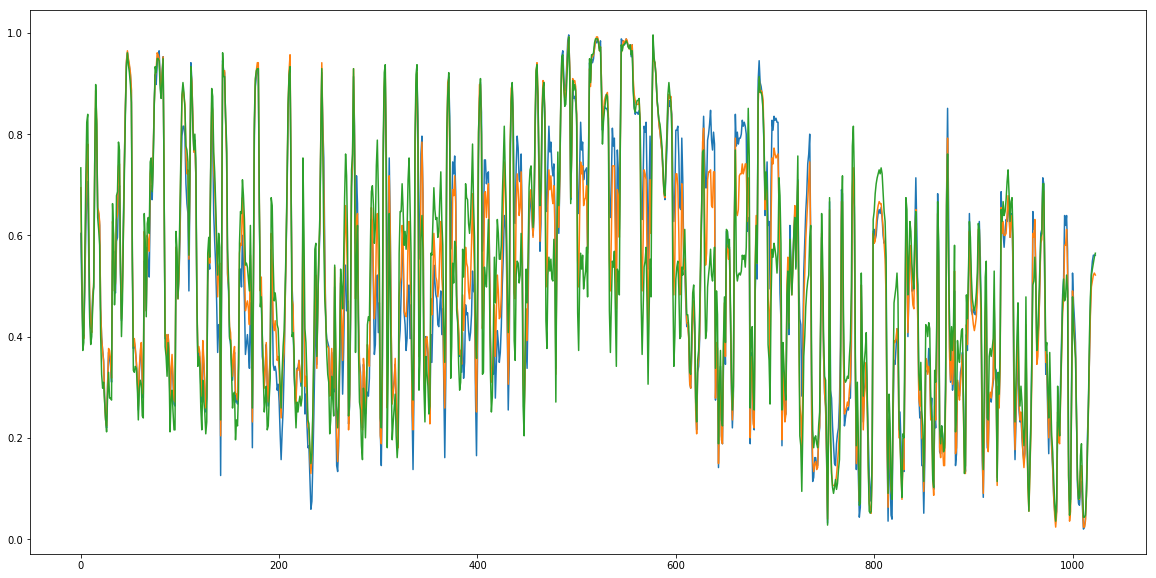

In [178]:
plt.figure(figsize=(20, 10))
print(y_train.numpy()[1])
plt.plot(x_train_f.numpy()[1])

In [175]:
train_loader = DataLoader(TensorDataset(x_train_f, y_train), shuffle=True, batch_size=128)
test_loader = DataLoader(TensorDataset(x_test_f, y_test), shuffle=True, batch_size=128)

In [176]:
model = AntisymmetricRNNModel(3, 10, n_units=256, gamma=0.01, eps=0.01, use_gating=True).cuda()
#opt = torch.optim.Adagrad(model.parameters(), lr=1)
opt = torch.optim.SGD(model.parameters(), momentum=0.5, lr=0.1)
loss = nn.CrossEntropyLoss()

In [179]:
for e in range(1000):
    time_start = time.time()
    ce_train, ce_test, acc_train, acc_test = 0, 0, 0, 0
    model.train()
    for batch_x, batch_y in train_loader:
        h = torch.zeros(batch_x.shape[0], 256).cuda()
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        output = model(batch_x, h)
        l = loss(output, batch_y.long())
        l.backward()
        opt.step()
        ce_train += l.item()*batch_x.shape[0]
        _, preds = torch.max(output, 1)
        acc_train += (preds == batch_y.long()).sum().item()
    ce_train /= len(x_train_f)
    acc_train = acc_train*100/len(x_train_f)
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            h = torch.zeros(batch_x.shape[0], 256).cuda()
            output = model(batch_x, h)
            l = loss(output, batch_y.long())
            ce_test += l.item()*batch_x.shape[0]
            _, preds = torch.max(output, 1)
            acc_test += (preds == batch_y.long()).sum().item()
    ce_test /= len(x_test_f)
    acc_test = acc_test*100/len(x_test_f)
    time_end = time.time()
    print("Iter: ", e, "train loss: ", ce_train, "train acc: ", acc_train,
          "test loss: ", ce_test, "test acc: ", acc_test, "iter time: ", time_end-time_start)

Iter:  0 train loss:  1.9688735904312133 train acc:  28.508 test loss:  1.8520230026245117 test acc:  35.12 iter time:  167.16023659706116
Iter:  1 train loss:  1.8314802606964111 train acc:  33.84 test loss:  1.7988505533218384 test acc:  34.41 iter time:  161.67102527618408
Iter:  2 train loss:  1.7694320757293702 train acc:  35.91 test loss:  1.7941126375198364 test acc:  34.17 iter time:  126.60331010818481
Iter:  3 train loss:  1.7302104861068726 train acc:  37.322 test loss:  1.7054367963790893 test acc:  38.41 iter time:  152.1093099117279
Iter:  4 train loss:  1.6994404290771485 train acc:  38.538 test loss:  1.6676963657379151 test acc:  39.76 iter time:  148.87915229797363
Iter:  5 train loss:  1.6714984103012085 train acc:  39.54 test loss:  1.6745578733444213 test acc:  38.81 iter time:  152.26862597465515
Iter:  6 train loss:  1.6481419269180297 train acc:  40.386 test loss:  1.6199565189361573 test acc:  40.84 iter time:  145.67898201942444
Iter:  7 train loss:  1.6279765

KeyboardInterrupt: 

In [182]:
predicts = []
true = []
outs = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        h = torch.zeros(batch_x.shape[0], 256).cuda()
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x, h)
        _, preds = torch.max(output, 1)
        predicts.append(preds.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        outs.append(output.detach().cpu().numpy())
predicts = np.concatenate(predicts)
true = np.concatenate(true)
outs = np.concatenate(outs)

In [183]:
accuracy_score(true, predicts)

0.4708